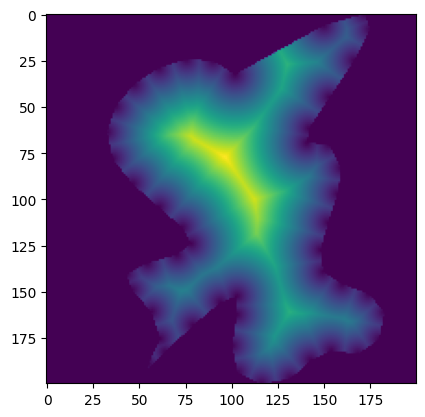

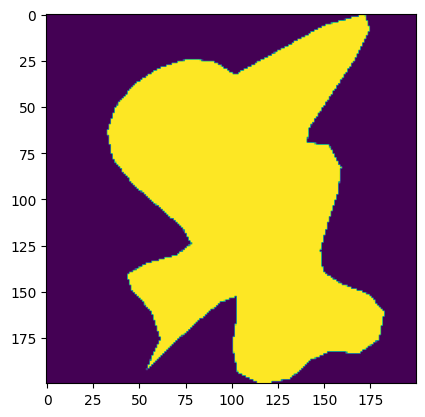

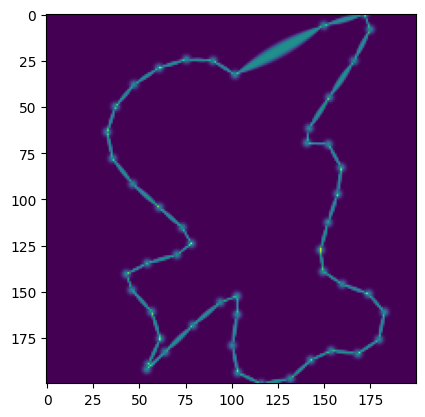

In [50]:
from torch_contour.torch_contour1 import area, perimeter, hausdorff_distance, Draw_contour, Contour_to_distance_map, Contour_to_mask, Draw_contour
import torch
import matplotlib.pyplot as plt

polygons1 = torch.tensor([[[[0.1640, 0.5085],
          [0.1267, 0.4491],
          [0.1228, 0.3772],
          [0.1461, 0.3027],
          [0.1907, 0.2356],
          [0.2503, 0.1857],
          [0.3190, 0.1630],
          [0.3905, 0.1774],
          [0.4595, 0.2317],
          [0.5227, 0.3037],
          [0.5774, 0.3658],
          [0.6208, 0.3905],
          [0.6505, 0.3513],
          [0.6738, 0.2714],
          [0.7029, 0.2152],
          [0.7461, 0.2298],
          [0.8049, 0.2828],
          [0.8776, 0.3064],
          [0.9473, 0.2744],
          [0.9606, 0.2701],
          [0.9138, 0.3192],
          [0.8415, 0.3947],
          [0.7793, 0.4689],
          [0.7627, 0.5137],
          [0.8124, 0.5142],
          [0.8961, 0.5011],
          [0.9696, 0.5158],
          [1.0000, 0.5795],
          [0.9858, 0.6581],
          [0.9355, 0.7131],
          [0.9104, 0.7682],
          [0.9184, 0.8406],
          [0.8799, 0.8974],
          [0.8058, 0.9121],
          [0.7568, 0.8694],
          [0.7305, 0.7982],
          [0.6964, 0.7466],
          [0.6378, 0.7394],
          [0.5639, 0.7597],
          [0.4864, 0.7858],
          [0.4153, 0.7953],
          [0.3524, 0.7609],
          [0.3484, 0.7028],
          [0.3092, 0.7089],
          [0.2255, 0.7632],
          [0.1265, 0.8300],
          [0.0416, 0.8736],
          [0.0000, 0.8584],
          [0.0310, 0.7486],
          [0.1640, 0.5085]]]], dtype=torch.float32)  

polygons2 = torch.tensor([[[[0.0460, 0.3955],
          [0.0000, 0.2690],
          [0.0179, 0.1957],
          [0.0789, 0.1496],
          [0.1622, 0.1049],
          [0.2495, 0.0566],
          [0.3287, 0.0543],
          [0.3925, 0.1280],
          [0.4451, 0.2231],
          [0.4928, 0.2692],
          [0.5436, 0.2215],
          [0.6133, 0.1419],
          [0.7077, 0.1118],
          [0.7603, 0.1569],
          [0.7405, 0.2511],
          [0.6742, 0.3440],
          [0.6042, 0.4099],
          [0.6036, 0.4780],
          [0.6693, 0.5520],
          [0.7396, 0.6100],
          [0.8190, 0.6502],
          [0.9172, 0.6815],
          [0.9818, 0.7310],
          [0.9605, 0.8186],
          [0.8830, 0.9023],
          [0.8048, 0.9205],
          [0.7506, 0.8514],
          [0.6597, 0.7975],
          [0.5866, 0.8195],
          [0.5988, 0.9145],
          [0.6419, 1.0000],
          [0.6529, 0.9978],
          [0.6253, 0.9186],
          [0.5714, 0.8027],
          [0.5035, 0.6905],
          [0.4340, 0.6223],
          [0.3713, 0.6260],
          [0.3116, 0.6854],
          [0.2478, 0.7748],
          [0.1732, 0.8687],
          [0.0892, 0.9420],
          [0.0353, 0.9737],
          [0.0452, 0.9514],
          [0.1028, 0.8855],
          [0.1831, 0.7907],
          [0.2610, 0.6817],
          [0.3113, 0.5730],
          [0.3090, 0.4793],
          [0.2289, 0.4153],
          [0.0460, 0.3955]]]], dtype = torch.float32)  
area_ = area(polygons1)
perimeter_ = perimeter(polygons1)
hausdorff_dists = hausdorff_distance(polygons1, polygons2)


Dmap = Contour_to_distance_map(200)
Mask = Contour_to_mask(200)
Draw = Draw_contour(200)


plt.imshow(Dmap(polygons1).cpu().detach().numpy()[0,0])
plt.show()
plt.imshow(Mask(polygons1).cpu().detach().numpy()[0,0])
plt.show()
plt.imshow(Draw(polygons1).cpu().detach().numpy()[0,0])
plt.show()

